# Genetic Algorithm Implementation
## Importing Required Libraries

We begin by importing the essential libraries for our genetic algorithm and visualization:
* `random`: Provides functions to generate random numbers, useful for creating and mutating populations.
* `matplotlib.pyplot`: Used for plotting the results and visualizing the shape of the parabolas.
* `numpy`: Supports efficient numerical operations, especially for evaluating mathematical functions.
* `prettytable`: Helps in creating clean, readable tables to display population data across generations.

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable

### Defining the Fitness Function for U-Shape Optimization

In this code, we define a fitness function that aims to create the flattest possible U-shape. This function is used for optimization, where the goal is to minimize the "curviness" of the parabola represented by the equation \(y = ax^2 + bx + c\).

1. **Parameters (`a`, `b`, `c`)**:
   - The parameters `a`, `b`, and `c` represent the coefficients of the quadratic equation \(y = ax^2 + bx + c\), which defines the U-shaped curve.

2. **Penalizing Downward Facing U-Shapes**:
   - The first condition checks if `a <= 0`, which would indicate a downward-facing parabola (i.e., the U-shape opens downward). We penalize this case heavily by returning a very large negative value (`-float('inf')`), as our objective is to optimize for a U-shape that opens upwards.

3. **Vertex Calculation**:
   - The vertex of the parabola is found at \(x = -\frac{b}{2a}\). This is the point where the curve reaches its minimum (if `a` is positive).
   - The corresponding `y` value at the vertex is calculated using the quadratic equation.

4. **Evaluating Curviness**:
   - To measure the "flattest" U-shape, we calculate the y-values of the parabola at \(x = -1\) and \(x = 1\), which represent points to the left and right of the vertex.
   - The curviness is defined as the sum of the absolute differences between the y-values at these points and the vertex y-value. The closer the y-values are to the vertex, the flatter the curve.

5. **Returning the Fitness Value**:
   - The fitness function returns the negative of the curviness, because in optimization, we typically minimize the objective function. By negating the curviness, we turn the task of minimizing curviness into a maximization problem, where the goal is to find the parameters that minimize the difference between the vertex and the surrounding points.

This function can be used in optimization algorithms, such as genetic algorithms or simulated annealing, to find the parameters that create the flattest U-shaped curve.


In [3]:
# Define the fitness function (objective is to create the flattest U-shape)
def fitness_function(params):
    a, b, c = params
    if a <= 0:
        return -float('inf')  # Penalize downward facing u-shapes heavily
    vertex_x = -b / (2 * a) #x value at vertex
    vertex_y = a * (vertex_x ** 2) + b * vertex_x + c #y value at vertex
    y_left = a * (-1) ** 2 + b * (-1) + c #y-coordinate at x = -1
    y_right = a * (1) ** 2 + b * (1) + c #y-coordinate at x = 1
    curviness = abs(y_left - vertex_y) + abs(y_right - vertex_y)
    return -curviness  # Negate to minimize curviness

### Creating the Initial Population for Optimization

In this code, we define a function to generate the initial population for an optimization algorithm, such as a genetic algorithm. The population consists of individuals, where each individual represents a set of parameters \((a, b, c)\) for the quadratic equation \(y = ax^2 + bx + c\). These parameters will be optimized to create the flattest U-shape.

1. **Function Parameters**:
   - `size`: The number of individuals in the initial population.
   - `lower_bound`: The minimum value that each parameter \(a\), \(b\), and \(c\) can take.
   - `upper_bound`: The maximum value that each parameter \(a\), \(b\), and \(c\) can take.

2. **Generating the Population**:
   - The population is created as a list of tuples, where each tuple represents an individual consisting of three randomly selected parameters: \(a\), \(b\), and \(c\).
   - For each parameter, the value is drawn from a uniform distribution between the `lower_bound` and `upper_bound` using `random.uniform()`. This ensures that the initial population consists of diverse candidates within the specified bounds.

3. **Returning the Population**:
   - The function returns the `population`, which is a list of tuples, each representing an individual with parameters \((a, b, c)\).

This initial population can be used in the first generation of an evolutionary or optimization algorithm, where individuals will undergo selection, mutation, and crossover to evolve towards the optimal solution.


In [4]:
# Create the initial population
def create_initial_population(size, lower_bound, upper_bound):
    population = []
    for _ in range(size):
        individual = (random.uniform(lower_bound, upper_bound),
                      random.uniform(lower_bound, upper_bound),
                      random.uniform(lower_bound, upper_bound))
        population.append(individual)
    return population

### Selection Function: Tournament Selection

This code defines a selection function based on **tournament selection**, a popular method used in genetic algorithms to choose individuals for the next generation. Tournament selection works by selecting a random subset of individuals (the "tournament") and choosing the best individual from this subset based on fitness.

1. **Function Parameters**:
   - `population`: A list of individuals, where each individual is represented by a tuple of parameters \((a, b, c)\).
   - `fitnesses`: A list of fitness values corresponding to each individual in the population.
   - `tournament_size`: The number of individuals to randomly select for each tournament. Default is 3.

2. **Tournament Selection Process**:
   - For each individual in the population, a tournament is held by randomly selecting a subset of individuals and their associated fitness values. The size of the tournament is controlled by the `tournament_size` parameter.
   - The `random.sample()` function is used to randomly choose individuals and their fitness values from the population.
   - The "winner" of the tournament is the individual with the highest fitness value. This is determined by using `max()` on the tournament subset, where the `key` function is the second element (fitness) of each tuple.

3. **Selecting Winners**:
   - The winner of each tournament is added to the `selected` list.
   - The selection process is repeated for each individual in the population, ensuring that a new generation of individuals is selected based on their fitness.

4. **Returning the Selected Individuals**:
   - The function returns the `selected` list, which contains the individuals chosen to form the next generation. These individuals will be used for crossover and mutation in the next steps of the algorithm.

Tournament selection promotes the survival of individuals with higher fitness while maintaining diversity through random selection within the tournaments.


In [5]:
# Selection function using tournament selection
def selection(population, fitnesses, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
        winner = max(tournament, key=lambda x: x[1])[0]
        selected.append(winner)
    return selected

### Crossover Function: Blended Crossover

This code defines the **crossover function** used to combine the genetic material of two parent individuals to produce offspring in a genetic algorithm. In this case, the function implements **blended crossover**, where the offspring inherit a weighted combination of their parents' parameters.

1. **Function Parameters**:
   - `parent1`: The first parent individual, represented as a tuple \((a_1, b_1, c_1)\), containing the parameters for the quadratic equation \(y = ax^2 + bx + c\).
   - `parent2`: The second parent individual, represented as a tuple \((a_2, b_2, c_2)\), containing the parameters for the quadratic equation.

2. **Alpha (Weight) for Blending**:
   - `alpha = random.random()`: A random value between 0 and 1 is generated to control how much of each parent contributes to the offspring. If `alpha` is close to 0, the offspring will resemble `parent2`; if `alpha` is close to 1, they will resemble `parent1`.

3. **Creating Offspring**:
   - The offspring, `child1` and `child2`, are created by blending the parameters of `parent1` and `parent2`. For each parameter (e.g., `a`, `b`, and `c`), the offspring inherit a weighted average of the respective parameters from the two parents:
     - For `child1`, the weight of `parent1` is controlled by `alpha`, and the weight of `parent2` is controlled by `(1 - alpha)`.
     - Similarly, `child2` is formed by swapping the contribution of each parent.
   - This blending ensures that both parents contribute to the genetic material of their children.

4. **Returning the Offspring**:
   - The function returns `child1` and `child2`, which are the offspring produced by the crossover of `parent1` and `parent2`.

This crossover function allows the genetic material from two parents to be recombined in a way that produces new individuals with characteristics inherited from both parents, which is essential for exploring the solution space in genetic algorithms.


In [6]:
# Crossover function
def crossover(parent1, parent2):
    alpha = random.random()
    child1 = tuple(alpha * p1 + (1 - alpha) * p2 for p1, p2 in zip(parent1, parent2))
    child2 = tuple(alpha * p2 + (1 - alpha) * p1 for p1, p2 in zip(parent1, parent2))
    return child1, child2

### Mutation Function: Random Perturbation

This code defines the **mutation function**, which introduces random changes to an individual in the population. Mutation is an essential operator in genetic algorithms, as it helps maintain genetic diversity and allows the algorithm to explore new regions of the solution space.

1. **Function Parameters**:
   - `individual`: A tuple representing an individual in the population (e.g., \((a, b, c)\)), where each element is a parameter of the quadratic equation \(y = ax^2 + bx + c\).
   - `mutation_rate`: The probability (between 0 and 1) that a parameter of the individual will be mutated.
   - `lower_bound`: The minimum value each parameter can take.
   - `upper_bound`: The maximum value each parameter can take.

2. **Mutation Process**:
   - The individual is first converted into a list to make it mutable (since tuples are immutable in Python).
   - The function then iterates over each parameter of the individual (i.e., `a`, `b`, and `c`).
   - For each parameter, a random number is generated. If this number is less than the `mutation_rate`, the parameter is mutated:
     - A random mutation amount is generated between -1 and 1 using `random.uniform(-1, 1)`.
     - The parameter is updated by adding the mutation amount to its current value.
   
3. **Ensuring Boundaries**:
   - After the mutation, the updated parameter is constrained to stay within the specified bounds using `max(min(individual[i], upper_bound), lower_bound)`. This ensures that the parameter does not exceed the allowed range.

4. **Returning the Mutated Individual**:
   - After iterating over all parameters and applying any mutations, the individual is converted back to a tuple and returned as the mutated individual.

This mutation function allows random adjustments to the parameters of an individual, promoting genetic diversity and helping the algorithm avoid getting stuck in local optima.


In [7]:
# Mutation function
def mutation(individual, mutation_rate, lower_bound, upper_bound):
    individual = list(individual)
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            mutation_amount = random.uniform(-1, 1)
            individual[i] += mutation_amount
            # Ensure the individual stays within bounds
            individual[i] = max(min(individual[i], upper_bound), lower_bound)
    return tuple(individual)

### Main Genetic Algorithm Function

This function implements the **genetic algorithm** to optimize a set of parameters \((a, b, c)\) for a quadratic function, aiming to find the flattest U-shaped curve. It iterates through a set number of generations, applying selection, crossover, and mutation operators to evolve the population towards an optimal solution.

1. **Function Parameters**:
   - `population_size`: The number of individuals in each generation.
   - `lower_bound`: The lower bound for the parameter values.
   - `upper_bound`: The upper bound for the parameter values.
   - `generations`: The number of generations the algorithm will run.
   - `mutation_rate`: The probability of mutation occurring for each individual in each generation.

2. **Population Initialization**:
   - The algorithm starts by generating an initial population of individuals with random values for parameters \(a\), \(b\), and \(c\) within the specified bounds.

3. **Loop Over Generations**:
   - For each generation, the algorithm calculates the fitness of each individual using the `fitness_function`. It then selects the best-performing individuals using the `selection` function.
   - The selected individuals undergo **crossover** to produce offspring. Each pair of parents generates two children, and both children are subjected to **mutation**.
   - The new population is formed by replacing the old one, preserving the best individual from the previous generation to ensure that the best solution so far is not lost.

4. **Storing and Plotting Results**:
   - The best individual from each generation, along with its fitness value, is stored for analysis and visualization.
   - A table is created to display the evolution of the population across generations, showing the values of \(a\), \(b\), \(c\), and the fitness of the best individual in each generation.

5. **Plotting**:
   - The algorithm generates several plots to visualize the evolution:
     - **Parameter Evolution**: A plot showing how the values of \(a\), \(b\), and \(c\) change over generations.
     - **Fitness Evolution**: A plot of the best fitness values over generations, with a shaded range indicating the fitness range of the population.
     - **Quadratic Function Evolution**: A plot of the quadratic function for each generation, illustrating the changes in the function as the algorithm progresses.
     - **Colorbar**: A colorbar is added to the function plot to indicate the generation number corresponding to each curve.

6. **Returning the Best Solution**:
   - After the algorithm completes all generations, it returns the best individual (the one with the highest fitness) in the final population.

This genetic algorithm explores the search space of the quadratic function's parameters, evolving the population toward an optimal solution through selection, crossover, and mutation processes, while visualizing the progress of the algorithm over generations.


In [8]:
# Main genetic algorithm function
def genetic_algorithm(population_size, lower_bound, upper_bound, generations, mutation_rate):
    population = create_initial_population(population_size, lower_bound, upper_bound)
    
    # Prepare for plotting
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))  # 3 rows, 1 column for subplots
    best_performers = []
    all_populations = []

    # Prepare for table
    table = PrettyTable()
    table.field_names = ["Generation", "a", "b", "c", "Fitness"]

    for generation in range(generations):
        fitnesses = [fitness_function(ind) for ind in population]

        # Store the best performer of the current generation
        best_individual = max(population, key=fitness_function)
        best_fitness = fitness_function(best_individual)
        best_performers.append((best_individual, best_fitness))
        all_populations.append(population[:])
        table.add_row([generation + 1, best_individual[0], best_individual[1], best_individual[2], best_fitness])

        population = selection(population, fitnesses)

        next_population = []
        for i in range(0, len(population), 2):
            parent1 = population[i]
            parent2 = population[i + 1]

            child1, child2 = crossover(parent1, parent2)

            next_population.append(mutation(child1, mutation_rate, lower_bound, upper_bound))
            next_population.append(mutation(child2, mutation_rate, lower_bound, upper_bound))

        # Replace the old population with the new one, preserving the best individual
        next_population[0] = best_individual
        population = next_population

    # Print the table
    print(table)

    # Plot the population of one generation (last generation)
    final_population = all_populations[-1]
    final_fitnesses = [fitness_function(ind) for ind in final_population]

    axs[0].scatter(range(len(final_population)), [ind[0] for ind in final_population], color='blue', label='a')
    axs[0].scatter([final_population.index(best_individual)], [best_individual[0]], color='cyan', s=100, label='Best Individual a')
    axs[0].set_ylabel('a', color='blue')
    axs[0].legend(loc='upper left')
    
    axs[1].scatter(range(len(final_population)), [ind[1] for ind in final_population], color='green', label='b')
    axs[1].scatter([final_population.index(best_individual)], [best_individual[1]], color='magenta', s=100, label='Best Individual b')
    axs[1].set_ylabel('b', color='green')
    axs[1].legend(loc='upper left')
    
    axs[2].scatter(range(len(final_population)), [ind[2] for ind in final_population], color='red', label='c')
    axs[2].scatter([final_population.index(best_individual)], [best_individual[2]], color='yellow', s=100, label='Best Individual c')
    axs[2].set_ylabel('c', color='red')
    axs[2].set_xlabel('Individual Index')
    axs[2].legend(loc='upper left')
    
    axs[0].set_title(f'Final Generation ({generations}) Population Solutions')

    # Plot the values of a, b, and c over generations
    generations_list = range(1, len(best_performers) + 1)
    a_values = [ind[0][0] for ind in best_performers]
    b_values = [ind[0][1] for ind in best_performers]
    c_values = [ind[0][2] for ind in best_performers]
    fig, ax = plt.subplots()
    ax.plot(generations_list, a_values, label='a', color='blue')
    ax.plot(generations_list, b_values, label='b', color='green')
    ax.plot(generations_list, c_values, label='c', color='red')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Parameter Values')
    ax.set_title('Parameter Values Over Generations')
    ax.legend()

    # Plot the fitness values over generations
    best_fitness_values = [fit[1] for fit in best_performers]
    min_fitness_values = [min([fitness_function(ind) for ind in population]) for population in all_populations]
    max_fitness_values = [max([fitness_function(ind) for ind in population]) for population in all_populations]
    fig, ax = plt.subplots()
    ax.plot(generations_list, best_fitness_values, label='Best Fitness', color='black')
    ax.fill_between(generations_list, min_fitness_values, max_fitness_values, color='gray', alpha=0.5, label='Fitness Range')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.set_title('Fitness Over Generations')
    ax.legend()

    # Plot the quadratic function for each generation
    fig, ax = plt.subplots()
    colors = plt.cm.viridis(np.linspace(0, 1, generations))
    for i, (best_ind, best_fit) in enumerate(best_performers):
        color = colors[i]
        a, b, c = best_ind
        x_range = np.linspace(lower_bound, upper_bound, 400)
        y_values = a * (x_range ** 2) + b * x_range + c
        ax.plot(x_range, y_values, color=color)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Quadratic Function')

    # Create a subplot for the colorbar
    cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
    norm = plt.cm.colors.Normalize(vmin=0, vmax=generations)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, cax=cax, orientation='vertical', label='Generation')

    plt.show()

    return max(population, key=fitness_function)

### Running the Genetic Algorithm

- Set parameters for the genetic algorithm:
  - `population_size`: Total individuals in each generation.
  - `lower_bound` and `upper_bound`: Range for the values of parameters \(a\), \(b\), and \(c\).
  - `generations`: Number of iterations to evolve the population.
  - `mutation_rate`: Probability of mutation per parameter.

- Executed the genetic algorithm to optimize a quadratic function for the flattest U-shape.
- The best solution with parameters \(a\), \(b\), and \(c\) is printed at the end.

+------------+----------------------+-----------------------+--------------------+----------------------+
| Generation |          a           |           b           |         c          |       Fitness        |
+------------+----------------------+-----------------------+--------------------+----------------------+
|     1      |   4.17358242361685   |   0.6334955212422102  |  12.278746192137   |  -8.395243036987786  |
|     2      |   4.17358242361685   |   0.6334955212422102  |  12.278746192137   |  -8.395243036987786  |
|     3      |  3.021642222880903   |   -2.417435772058082  | 13.649333307539948 |  -7.010307554549028  |
|     4      |  3.021642222880903   |   -2.417435772058082  | 13.649333307539948 |  -7.010307554549028  |
|     5      |  3.2028175854320455  |  -0.8908409398227702  | 14.898505965925594 |  -6.52952570769547   |
|     6      |  2.8550201303510727  | -0.038862244054184814 | 13.968048130874767 |  -5.710304755161726  |
|     7      |  2.2556750066138154  |    -1.70

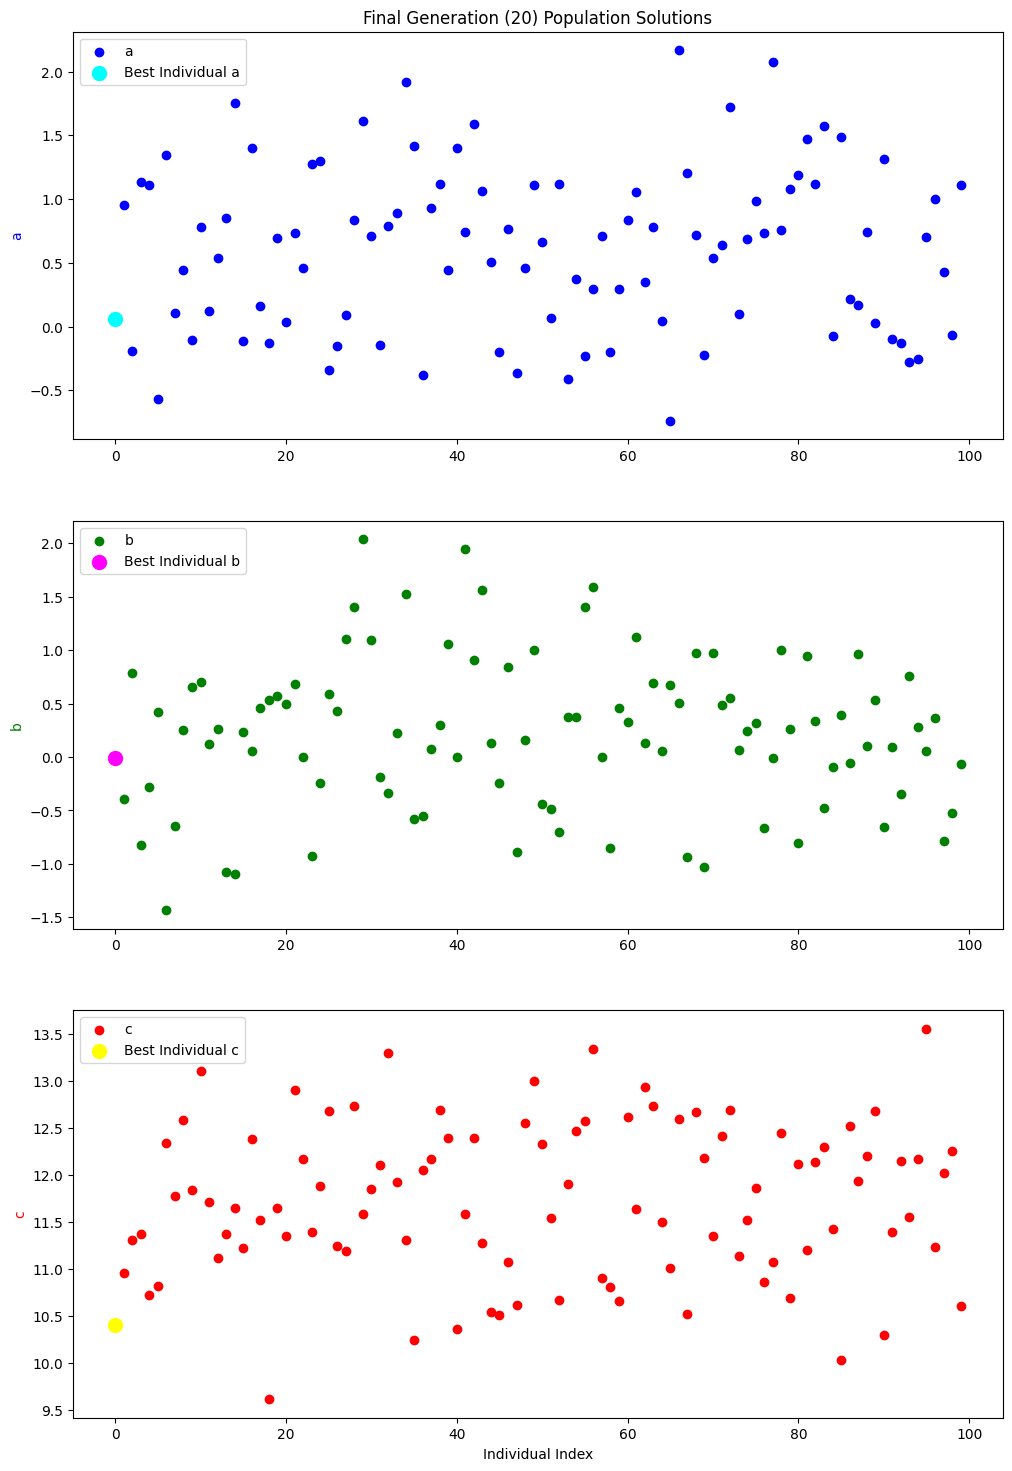

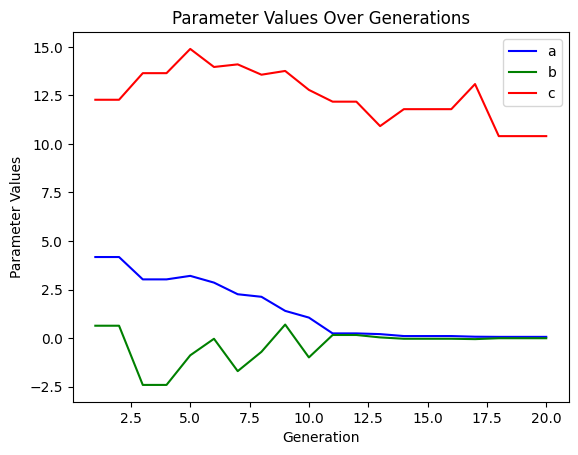

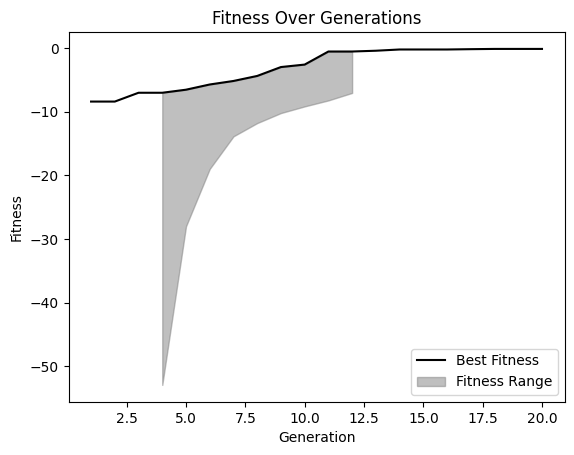

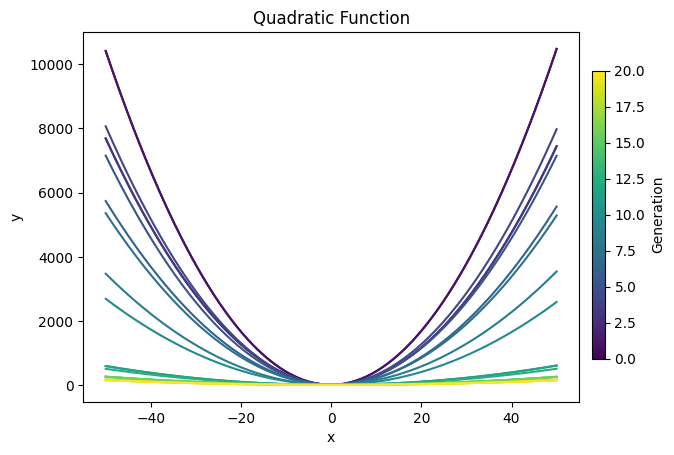

Best solution found: a = 0.059189612860924945, b = -0.011252969534279122, c = 10.404349279830123


In [9]:
# Parameters for the genetic algorithm
population_size = 100
lower_bound = -50
upper_bound = 50
generations = 20
mutation_rate = 1

# Run the genetic algorithm
best_solution = genetic_algorithm(population_size, lower_bound, upper_bound, generations, mutation_rate)
print(f"Best solution found: a = {best_solution[0]}, b = {best_solution[1]}, c = {best_solution[2]}")

Termination Condition Function

This function is responsible for checking if the genetic algorithm has reached its stopping criterion. The stopping condition is based on the fitness value: if the best fitness value in the current population reaches or exceeds a predefined target fitness value, the algorithm will terminate.
Function Explanation:
termination_condition(fitnesses, target_fitness)

    fitnesses: A list of fitness values for all individuals in the current generation.

    target_fitness: The target fitness value that we want the algorithm to achieve.

The function returns True if the maximum fitness in the population is greater than or equal to the target fitness, indicating that the algorithm has converged to an acceptable solution.

In [10]:
def termination_condition(fitnesses, target_fitness):
    return max(fitnesses) >= target_fitness

## Complete Code

+------------+---------------------+----------------------+---------------------+----------------------+
| Generation |          a          |          b           |          c          |       Fitness        |
+------------+---------------------+----------------------+---------------------+----------------------+
|     1      |   8.53290534280363  |  -7.03939661762778   | -41.158272799137784 |  -19.96945854934812  |
|     2      |   8.53290534280363  |  -7.03939661762778   | -41.158272799137784 |  -19.96945854934812  |
|     3      |  9.508496401651119  |  1.0661022497663062  |  46.57131759246747  | -19.076759035466942  |
|     4      |  7.331517171181812  | -0.9459574725159234  |  36.93705192174016  | -14.724060970203091  |
|     5      |   6.98169179850327  | -0.8942820342067992  |  29.650247760409677 | -14.020657706189972  |
|     6      |  6.289580218892262  | -2.6069218260916607  |  33.36864471995222  | -13.119422360745574  |
|     7      |  5.427074187502766  | -1.428546295512196

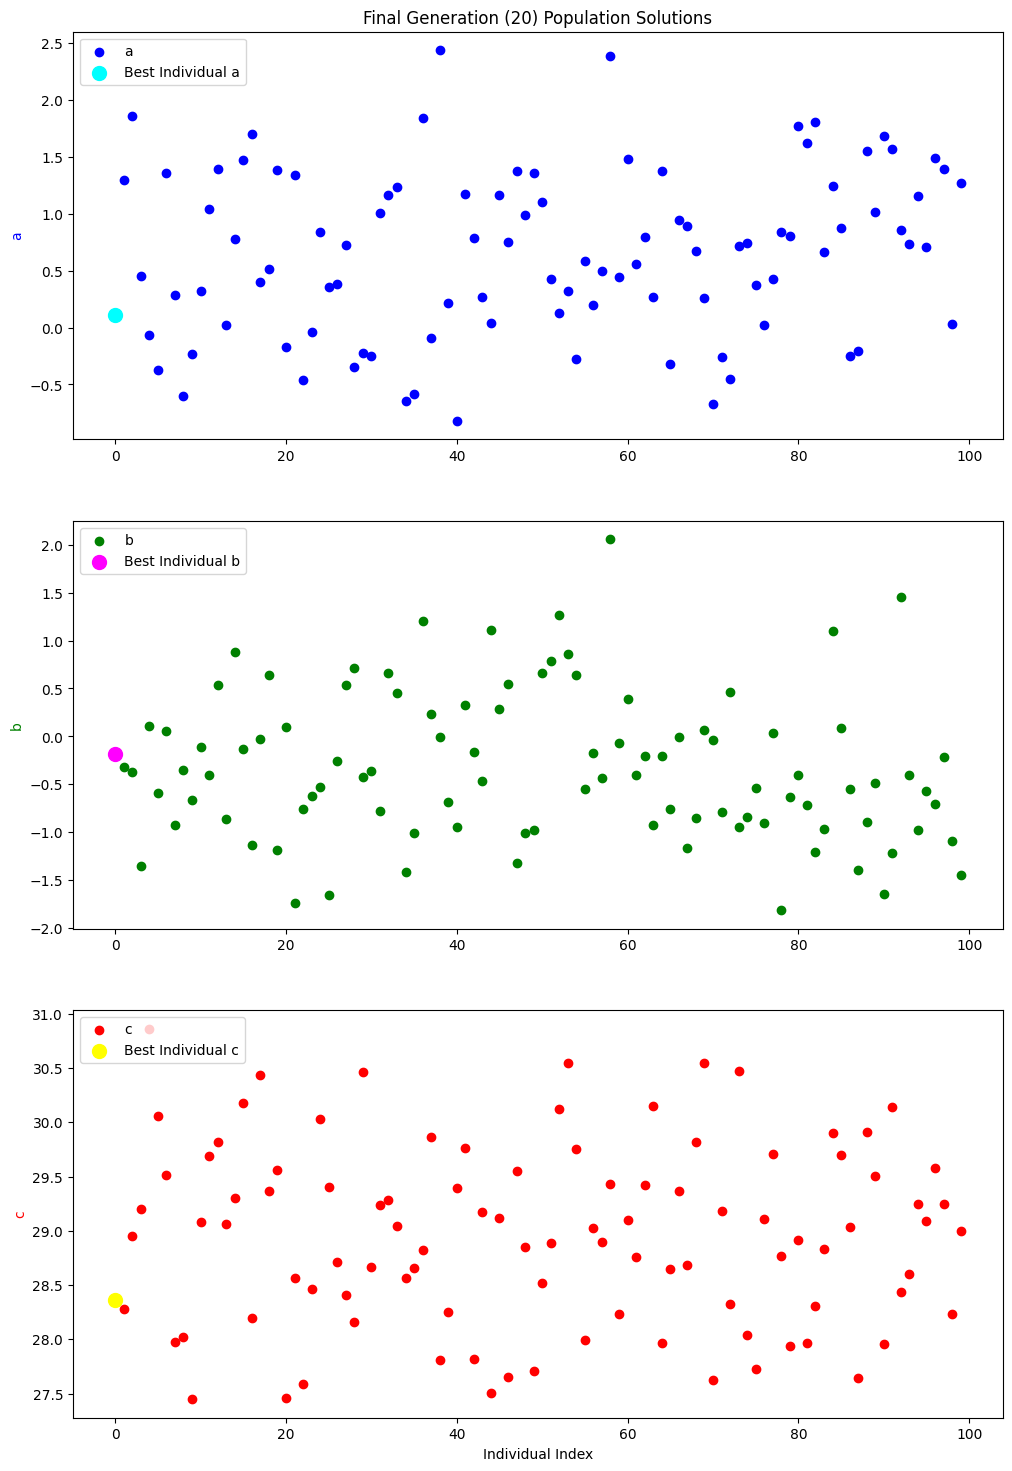

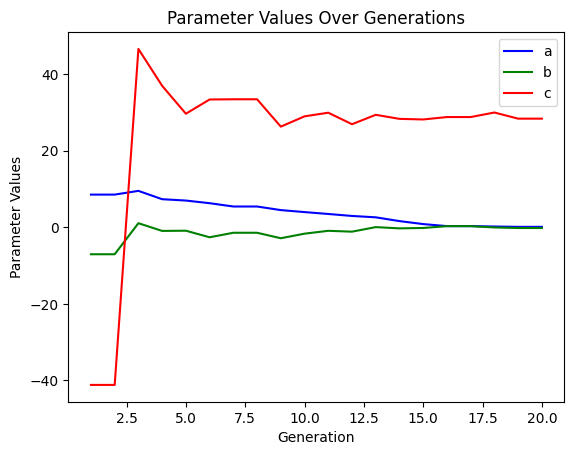

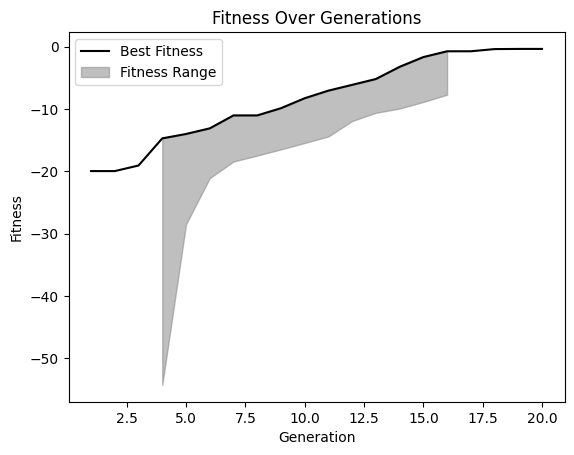

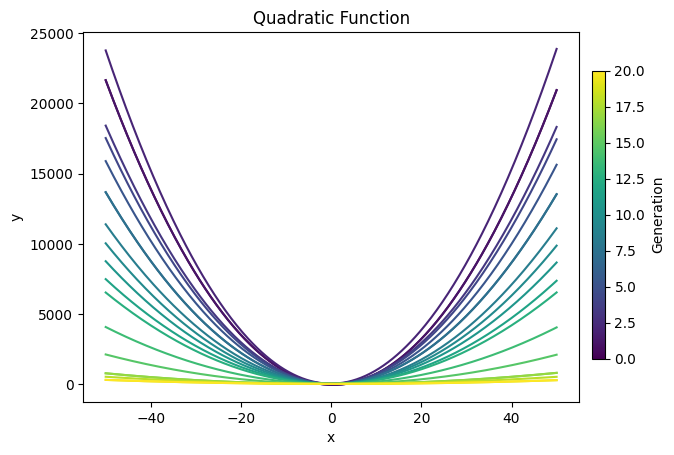

Best solution found: a = 0.1716405069126684, b = 0.09233772835915227, c = 29.413146094754968


In [11]:
import random
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable

# Define the fitness function (objective is to create the flattest U-shape)
def fitness_function(params):
    a, b, c = params
    if a <= 0:
        return -float('inf')  # Penalize downward facing u-shapes heavily
    vertex_x = -b / (2 * a) #x value at vertex
    vertex_y = a * (vertex_x ** 2) + b * vertex_x + c #y value at vertex
    y_left = a * (-1) ** 2 + b * (-1) + c #y-coordinate at x = -1
    y_right = a * (1) ** 2 + b * (1) + c #y-coordinate at x = 1
    curviness = abs(y_left - vertex_y) + abs(y_right - vertex_y)
    return -curviness  # Negate to minimize curviness

# Create the initial population
def create_initial_population(size, lower_bound, upper_bound):
    population = []
    for _ in range(size):
        individual = (random.uniform(lower_bound, upper_bound),
                      random.uniform(lower_bound, upper_bound),
                      random.uniform(lower_bound, upper_bound))
        population.append(individual)
    return population

# Selection function using tournament selection
def selection(population, fitnesses, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
        winner = max(tournament, key=lambda x: x[1])[0]
        selected.append(winner)
    return selected

# Crossover function
def crossover(parent1, parent2):
    alpha = random.random()
    child1 = tuple(alpha * p1 + (1 - alpha) * p2 for p1, p2 in zip(parent1, parent2))
    child2 = tuple(alpha * p2 + (1 - alpha) * p1 for p1, p2 in zip(parent1, parent2))
    return child1, child2

# Mutation function
def mutation(individual, mutation_rate, lower_bound, upper_bound):
    individual = list(individual)
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            mutation_amount = random.uniform(-1, 1)
            individual[i] += mutation_amount
            # Ensure the individual stays within bounds
            individual[i] = max(min(individual[i], upper_bound), lower_bound)
    return tuple(individual)

# Main genetic algorithm function
def genetic_algorithm(population_size, lower_bound, upper_bound, generations, mutation_rate):
    population = create_initial_population(population_size, lower_bound, upper_bound)
    
    # Prepare for plotting
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))  # 3 rows, 1 column for subplots
    best_performers = []
    all_populations = []

    # Prepare for table
    table = PrettyTable()
    table.field_names = ["Generation", "a", "b", "c", "Fitness"]

    for generation in range(generations):
        fitnesses = [fitness_function(ind) for ind in population]

        # Store the best performer of the current generation
        best_individual = max(population, key=fitness_function)
        best_fitness = fitness_function(best_individual)
        best_performers.append((best_individual, best_fitness))
        all_populations.append(population[:])
        table.add_row([generation + 1, best_individual[0], best_individual[1], best_individual[2], best_fitness])

        population = selection(population, fitnesses)

        next_population = []
        for i in range(0, len(population), 2):
            parent1 = population[i]
            parent2 = population[i + 1]

            child1, child2 = crossover(parent1, parent2)

            next_population.append(mutation(child1, mutation_rate, lower_bound, upper_bound))
            next_population.append(mutation(child2, mutation_rate, lower_bound, upper_bound))

        # Replace the old population with the new one, preserving the best individual
        next_population[0] = best_individual
        population = next_population

    # Print the table
    print(table)

    # Plot the population of one generation (last generation)
    final_population = all_populations[-1]
    final_fitnesses = [fitness_function(ind) for ind in final_population]

    axs[0].scatter(range(len(final_population)), [ind[0] for ind in final_population], color='blue', label='a')
    axs[0].scatter([final_population.index(best_individual)], [best_individual[0]], color='cyan', s=100, label='Best Individual a')
    axs[0].set_ylabel('a', color='blue')
    axs[0].legend(loc='upper left')
    
    axs[1].scatter(range(len(final_population)), [ind[1] for ind in final_population], color='green', label='b')
    axs[1].scatter([final_population.index(best_individual)], [best_individual[1]], color='magenta', s=100, label='Best Individual b')
    axs[1].set_ylabel('b', color='green')
    axs[1].legend(loc='upper left')
    
    axs[2].scatter(range(len(final_population)), [ind[2] for ind in final_population], color='red', label='c')
    axs[2].scatter([final_population.index(best_individual)], [best_individual[2]], color='yellow', s=100, label='Best Individual c')
    axs[2].set_ylabel('c', color='red')
    axs[2].set_xlabel('Individual Index')
    axs[2].legend(loc='upper left')
    
    axs[0].set_title(f'Final Generation ({generations}) Population Solutions')

    # Plot the values of a, b, and c over generations
    generations_list = range(1, len(best_performers) + 1)
    a_values = [ind[0][0] for ind in best_performers]
    b_values = [ind[0][1] for ind in best_performers]
    c_values = [ind[0][2] for ind in best_performers]
    fig, ax = plt.subplots()
    ax.plot(generations_list, a_values, label='a', color='blue')
    ax.plot(generations_list, b_values, label='b', color='green')
    ax.plot(generations_list, c_values, label='c', color='red')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Parameter Values')
    ax.set_title('Parameter Values Over Generations')
    ax.legend()

    # Plot the fitness values over generations
    best_fitness_values = [fit[1] for fit in best_performers]
    min_fitness_values = [min([fitness_function(ind) for ind in population]) for population in all_populations]
    max_fitness_values = [max([fitness_function(ind) for ind in population]) for population in all_populations]
    fig, ax = plt.subplots()
    ax.plot(generations_list, best_fitness_values, label='Best Fitness', color='black')
    ax.fill_between(generations_list, min_fitness_values, max_fitness_values, color='gray', alpha=0.5, label='Fitness Range')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.set_title('Fitness Over Generations')
    ax.legend()

    # Plot the quadratic function for each generation
    fig, ax = plt.subplots()
    colors = plt.cm.viridis(np.linspace(0, 1, generations))
    for i, (best_ind, best_fit) in enumerate(best_performers):
        color = colors[i]
        a, b, c = best_ind
        x_range = np.linspace(lower_bound, upper_bound, 400)
        y_values = a * (x_range ** 2) + b * x_range + c
        ax.plot(x_range, y_values, color=color)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Quadratic Function')

    # Create a subplot for the colorbar
    cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
    norm = plt.cm.colors.Normalize(vmin=0, vmax=generations)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, cax=cax, orientation='vertical', label='Generation')

    plt.show()

    return max(population, key=fitness_function)

# Parameters for the genetic algorithm
population_size = 100
lower_bound = -50
upper_bound = 50
generations = 20
mutation_rate = 1

# Run the genetic algorithm
best_solution = genetic_algorithm(population_size, lower_bound, upper_bound, generations, mutation_rate)
print(f"Best solution found: a = {best_solution[0]}, b = {best_solution[1]}, c = {best_solution[2]}")